# Model Selection and Evaluation
* 1 Cross-validation: evaluating estimator performance
* 2 Tuning the hyper-parameters of an estimator
* 3 Model evaluation: quantifying the quality of predictions
* 4 Model persistence
* 5 Validation curves: plotting scores to evaluate models

## 四、Model persistence

### 1 Persistence example

In [11]:
# using Python’s built-in persistence model, namely pickle
from sklearn import svm
from sklearn import datasets

clf = svm.SVC()
iris = datasets.load_iris()
X, y = iris.data, iris.target
print(clf.fit(X, y))
print()

import pickle

s = pickle.dumps(clf)
clf2 = pickle.loads(s)
print(clf2.predict(X[0:1]))

y[0]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[0]


0

In [12]:
from sklearn.externals import joblib

joblib.dump(clf, 'filename.pkl') 

# load back the pickled model (possibly in another Python process)
clf = joblib.load('filename.pkl') 

* Note：joblib.dump and joblib.load functions also accept file-like object instead of filenames.

### 2 Security & maintainability limitations

* pickle (and joblib by extension), has some issues regarding maintainability and security. Because of this
> * Never unpickle untrusted data as it could lead to malicious code being executed upon loading.
> * While models saved using one version of scikit-learn might load in other versions, this is entirely unsupported and inadvisable. It should also be kept in mind that operations performed on such data could give different and unexpected results.
* In order to rebuild a similar model with future versions of scikit-learn, additional metadata should be saved along the pickled model:
> * The training data, e.g. a reference to a immutable snapshot
> * The python source code used to generate the model
> * The versions of scikit-learn and its dependencies
> * The cross validation score obtained on the training data

## 五、Validation curves: plotting scores to evaluate models

* Every estimator has its advantages and drawbacks. 
* Its generalization error can be decomposed in terms of bias, variance and noise. 
> * The bias of an estimator is its average error for different training sets. 
> * The variance of an estimator indicates how sensitive it is to varying training sets. 
> * Noise is a property of the data.
* Bias and variance are inherent properties of estimators and we usually have to select learning algorithms and hyperparameters so that both bias and variance are as low as possible (see Bias-variance dilemma). 
* Another way to reduce the variance of a model is to use more training data. 
* However, you should only collect more training data if the true function is too complex to be approximated by an estimator with a lower variance.

### 1 Underfitting vs. Overfitting

Automatically created module for IPython interactive environment


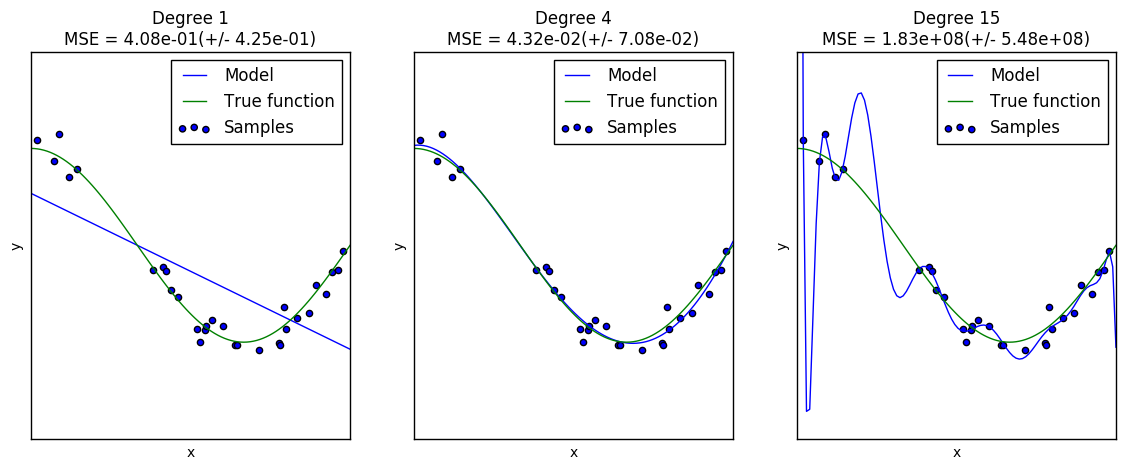

In [3]:
# This example demonstrates the problems of underfitting and overfitting 
# and how we can use linear regression with polynomial features to approximate nonlinear functions. 

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

* the first estimator can at best provide only a poor fit to the samples and the true function because it is too simple (high bias)
* the second estimator approximates it almost perfectly 
* the last estimator approximates the training data perfectly but does not fit the true function very well, i.e. it is very sensitive to varying training data (high variance).

* The plot shows the function that we want to approximate, which is a part of the cosine function. 
* In addition, the samples from the real function and the approximations of different models are displayed. 
* The models have polynomial features of different degrees. 
> * a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called underfitting. 
> * A polynomial of degree 4 approximates the true function almost perfectly. 
> * for higher degrees the model will overfit the training data, i.e. it learns the noise of the training data. 
* We evaluate quantitatively overfitting / underfitting by using cross-validation. 
* We calculate the mean squared error (MSE) on the validation set, the higher, the less likely the model generalizes correctly from the training data.

### 2 Validation curve

* If the training score and the validation score are both low, the estimator will be underfitting. 
* If the training score is high and the validation score is low, the estimator is overfitting 
* otherwise it is working very well. A low training score and a high validation score is usually not possible. 
* All three cases can be found in the plot below where we vary the parameter \gamma of an SVM on the digits dataset.

Automatically created module for IPython interactive environment


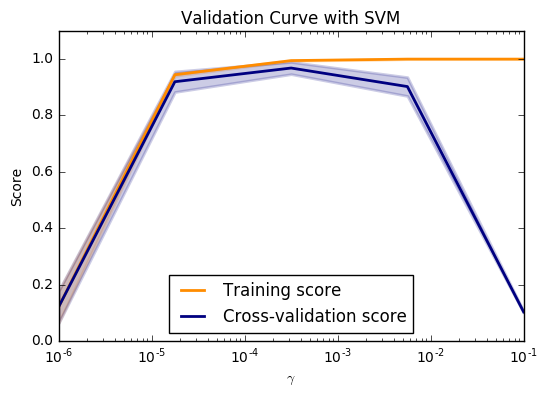

In [4]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

* In this plot you can see the training scores and validation scores of an SVM for different values of the kernel parameter gamma. 
* For very low values of gamma, you can see that both the training score and the validation score are low. 
* This is called underfitting. 
* Medium values of gamma will result in high values for both scores, i.e. the classifier is performing fairly well. 
* If gamma is too high, the classifier will overfit, which means that the training score is good but the validation score is poor.

* it is sometimes helpful to plot the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values

In [14]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

np.random.seed(0)
iris = load_iris()
X, y = iris.data, iris.target
indices = np.arange(y.shape[0])
print(np.random.shuffle(indices))
X, y = X[indices], y[indices]

train_scores, valid_scores = validation_curve(Ridge(), X, y, "alpha",np.logspace(-7, 3, 3))
print(train_scores)

valid_scores  

None
[[ 0.94141575  0.92944161  0.92267644]
 [ 0.94141563  0.92944153  0.92267633]
 [ 0.47253778  0.45601093  0.42887489]]


array([[ 0.90335825,  0.92525985,  0.94159336],
       [ 0.90338529,  0.92523396,  0.94159078],
       [ 0.44639995,  0.39639757,  0.4567671 ]])

### 3 Learning curve

* A learning curve shows the validation and training score of an estimator for varying numbers of training samples. 
* It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. 
* If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.
> * In the following plot you can see an example: naive Bayes roughly converges to a low score.

* We will probably have to use an estimator or a parametrization of the current estimator that can learn more complex concepts (i.e. has a lower bias). 
* If the training score is much greater than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization. 
> * In the following plot you can see that the SVM could benefit from more training examples.

Automatically created module for IPython interactive environment


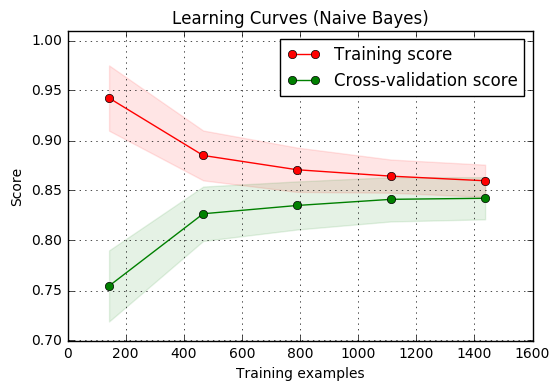

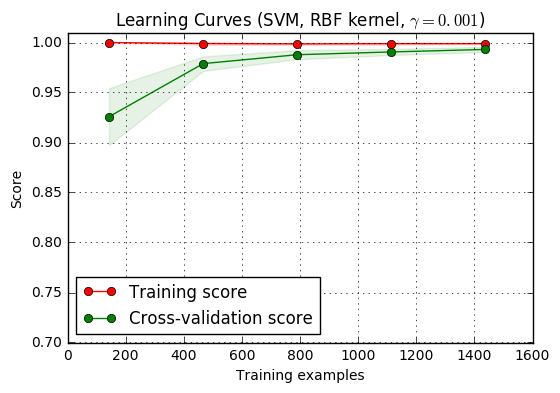

In [5]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

digits = load_digits()
X, y = digits.data, digits.target

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

* On the left side the learning curve of a naive Bayes classifier is shown for the digits dataset. 
* Note that the training score and the cross-validation score are both not very good at the end. 
* However, the shape of the curve can be found in more complex datasets very often: the training score is very high at the beginning and decreases and the cross-validation score is very low at the beginning and increases. 
* On the right side we see the learning curve of an SVM with RBF kernel. 
* We can see clearly that the training score is still around the maximum and the validation score could be increased with more training samples.

In [15]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

train_sizes, train_scores, valid_scores = learning_curve(
    SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)
print(train_sizes)            
print()
print(train_scores)           
print()
valid_scores 

[ 50  80 110]

[[ 0.98        0.98        0.98        0.98        0.98      ]
 [ 0.9875      1.          0.9875      0.9875      0.9875    ]
 [ 0.98181818  1.          0.98181818  0.98181818  0.99090909]]



array([[ 1.        ,  0.93333333,  1.        ,  1.        ,  0.96666667],
       [ 1.        ,  0.96666667,  1.        ,  1.        ,  0.96666667],
       [ 1.        ,  0.96666667,  1.        ,  1.        ,  0.96666667]])